In [1]:
import os
import math
import itertools
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import PyQt6
from scipy.stats import pearsonr
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
import warnings
import pywt

warnings.simplefilter(action='ignore', category=FutureWarning)


In [3]:
# load and normalize data
path = 'group_dataset/' 
def pre_process(path, subject):
    if subject == 'all':
            all_files = glob.glob(os.path.join(path, "**/*.csv"))
    else:
        all_files = glob.glob(os.path.join(path , subject, "*.csv"))

    dfs = list()

    for f in all_files:
        data = pd.read_csv(f)
        person = f.split('/')[1]
        data['activity'] = f.split('/')[2]
        data['person'] = person
        dfs.append(data)
    df = pd.concat(dfs, ignore_index=True)

    # remove data <10s and >90s
    df = df[df['loggingTime(txt)'] >= 1000]
    df = df[df['loggingTime(txt)'] <= 5500]

    # rename activity labels
    df['activity'] = df['activity'].replace('\d+', '', regex=True)
    df['activity'] = df['activity'].str.lstrip('-_')
    df['activity'] = df['activity'].str.rstrip('.csv')

    # add time column
    df['time'] = df['loggingTime(txt)']/100

    # normalize data
    # data preprocessing
    # normalize each channel of accelerometer to zero mean and standard deviation of one by subtracting mean and dividing by standard deviation
    x_mean = np.mean(df['accelerometerAccelerationX(G)'])
    x_std = np.std(df['accelerometerAccelerationX(G)'])
    y_mean = np.mean(df['accelerometerAccelerationY(G)'])
    y_std = np.std(df['accelerometerAccelerationY(G)'])
    z_mean = np.mean(df['accelerometerAccelerationZ(G)'])
    z_std = np.std(df['accelerometerAccelerationZ(G)'])

    df['accelerometerAccelerationX(G)'] = df['accelerometerAccelerationX(G)'].apply(lambda x: (x - x_mean)/x_std)
    df['accelerometerAccelerationY(G)'] = df['accelerometerAccelerationY(G)'].apply(lambda y: (y - y_mean)/y_std)
    df['accelerometerAccelerationZ(G)'] = df['accelerometerAccelerationZ(G)'].apply(lambda z: (z - z_mean)/z_std)

    return df

In [4]:
def extract_features(df):
    # DATA SEGMENTATION
    # segment data into windows of length 512 with 256 samples overlapping between consecutive windows
    x_list = [] # 350 x 512 (350 windows, each window of length 512)
    y_list = []
    z_list = []
    labels = []
    frame_size = 128
    hop_size = 64
    for i in range(0, len(df) - frame_size, hop_size):

        x = df['accelerometerAccelerationX(G)'].values[i: i + frame_size]
        y = df['accelerometerAccelerationY(G)'].values[i: i + frame_size]
        z = df['accelerometerAccelerationZ(G)'].values[i: i + frame_size]
        
        # Use most often used label in this segment as the label for the overall frame
        label = stats.mode(df['activity'][i: i + frame_size])[0][0]
        x_list.append(x)
        y_list.append(y)
        z_list.append(z)
        labels.append(label)
    
    # FEATURE EXTRACTION
    # extract mean, std, fft energy and correlation of each window
    # selected these features due to this paper https://www.aaai.org/Papers/IAAI/2005/IAAI05-013.pdf
    X = pd.DataFrame()
    y = labels
    # mean of each window
    X['x_mean'] = pd.Series(x_list).apply(lambda x: x.mean()) 
    X['y_mean'] = pd.Series(x_list).apply(lambda x: x.mean())
    X['z_mean'] = pd.Series(x_list).apply(lambda x: x.mean())

    # standard deviation
    X['x_std'] = pd.Series(x_list).apply(lambda x: x.std())
    X['y_std'] = pd.Series(y_list).apply(lambda x: x.std())
    X['z_std'] = pd.Series(z_list).apply(lambda x: x.std())

    # FFT energy
    x_list_fft = pd.Series(x_list).apply(lambda x: np.abs(np.fft.fft(x))[1:int(frame_size/2)+1])
    y_list_fft = pd.Series(y_list).apply(lambda x: np.abs(np.fft.fft(x))[1:int(frame_size/2)+1])
    z_list_fft = pd.Series(z_list).apply(lambda x: np.abs(np.fft.fft(x))[1:int(frame_size/2)+1])

    X['x_fft_energy'] = pd.Series(x_list).apply(lambda x: np.sum(x**2)/int(frame_size/2))
    X['y_fft_energy'] = pd.Series(y_list).apply(lambda x: np.sum(x**2)/int(frame_size/2))
    X['z_fft_energy'] = pd.Series(z_list).apply(lambda x: np.sum(x**2)/int(frame_size/2))

    # correlation
    corr_xy_list = []
    corr_yz_list = []
    corr_xz_list = []

    for i in range(0, len(x_list)):
        corr_xy, _ = pearsonr(x_list[i], y_list[i])
        corr_yz, _ = pearsonr(y_list[i], z_list[i])
        corr_xz, _ = pearsonr(x_list[i], z_list[i])

        corr_xy_list.append(corr_xy)
        corr_yz_list.append(corr_yz)
        corr_xz_list.append(corr_xz)
    X['xy_corr'] = corr_xy_list
    X['yz_corr'] = corr_yz_list
    X['xz_corr'] = corr_xz_list

    x_mag = [i**2 for i in X['x_mean']]
    y_mag = [i**2 for i in X['y_mean']]
    z_mag = [i**2 for i in X['z_mean']]
    mag_sum = [sum(x) for x in zip(x_mag, y_mag, z_mag)]

    X['mag'] = np.sqrt(mag_sum)
    return (X, y)

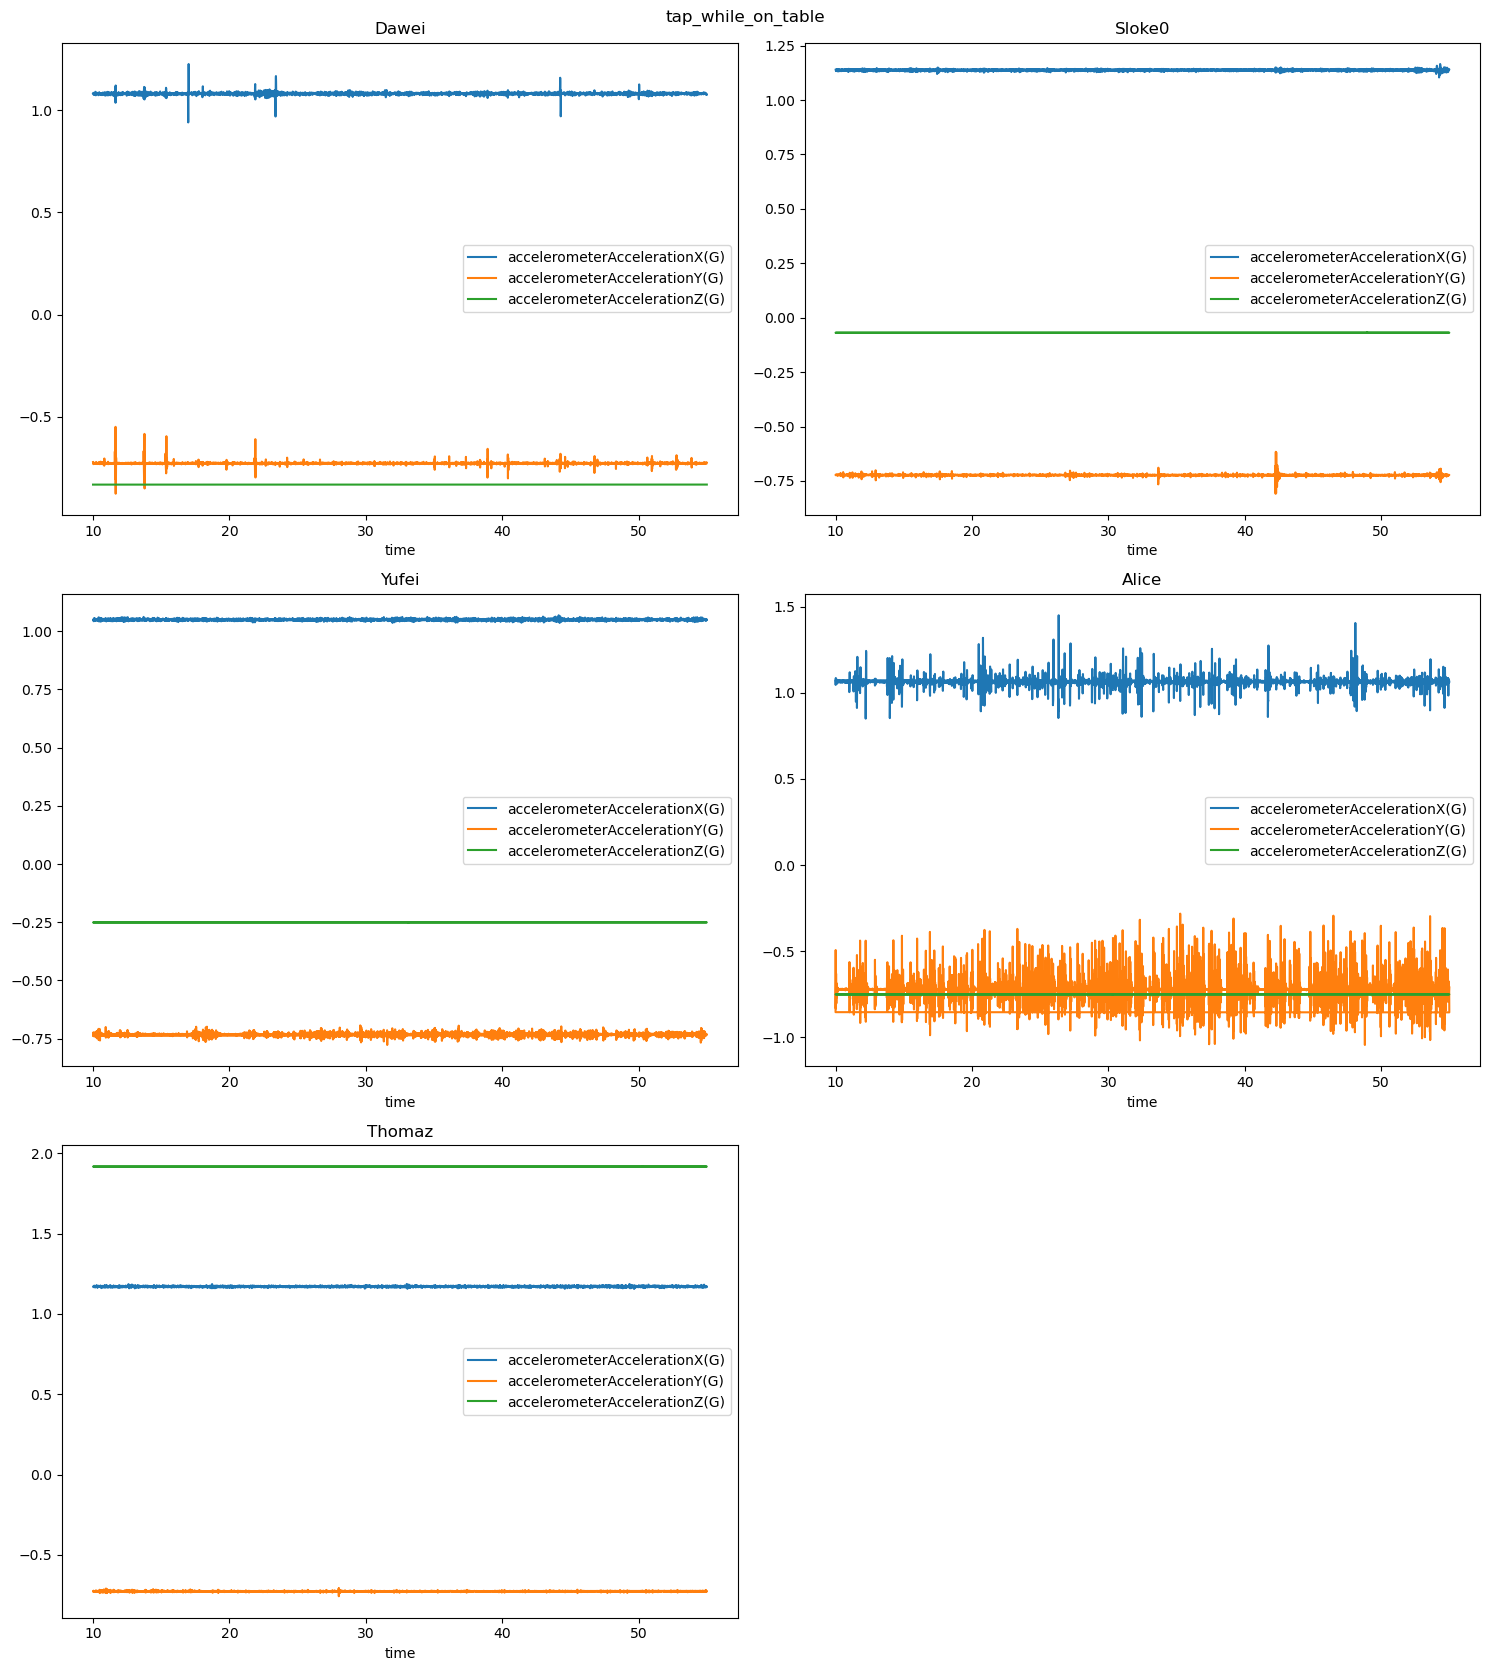

In [5]:
# plot raw normalized data, same activity across different participants
df = pre_process(path, subject="all")

activity_list = df['activity'].unique()
person_list = df['person'].unique()

activity = "tap_while_on_table"
activity_indices = df[df['activity']==activity].index
i = 1
plt.figure(figsize=(15, 17))

for person in person_list:
    person_indices = df[df['person']==person].index
    plot_indices = list(set(activity_indices) & set(person_indices))
    plot_df = df.loc[plot_indices]
    ax = plt.subplot(3, 2, i)
    plot_df.plot(x="time", y="accelerometerAccelerationX(G)", ax=ax)
    plot_df.plot(x="time", y="accelerometerAccelerationY(G)", ax=ax)
    plot_df.plot(x="time", y="accelerometerAccelerationZ(G)", ax=ax)

    plt.title("{person}".format(person=person))
    i=i+1

plt.suptitle("{activity}".format(activity=activity))
plt.tight_layout()

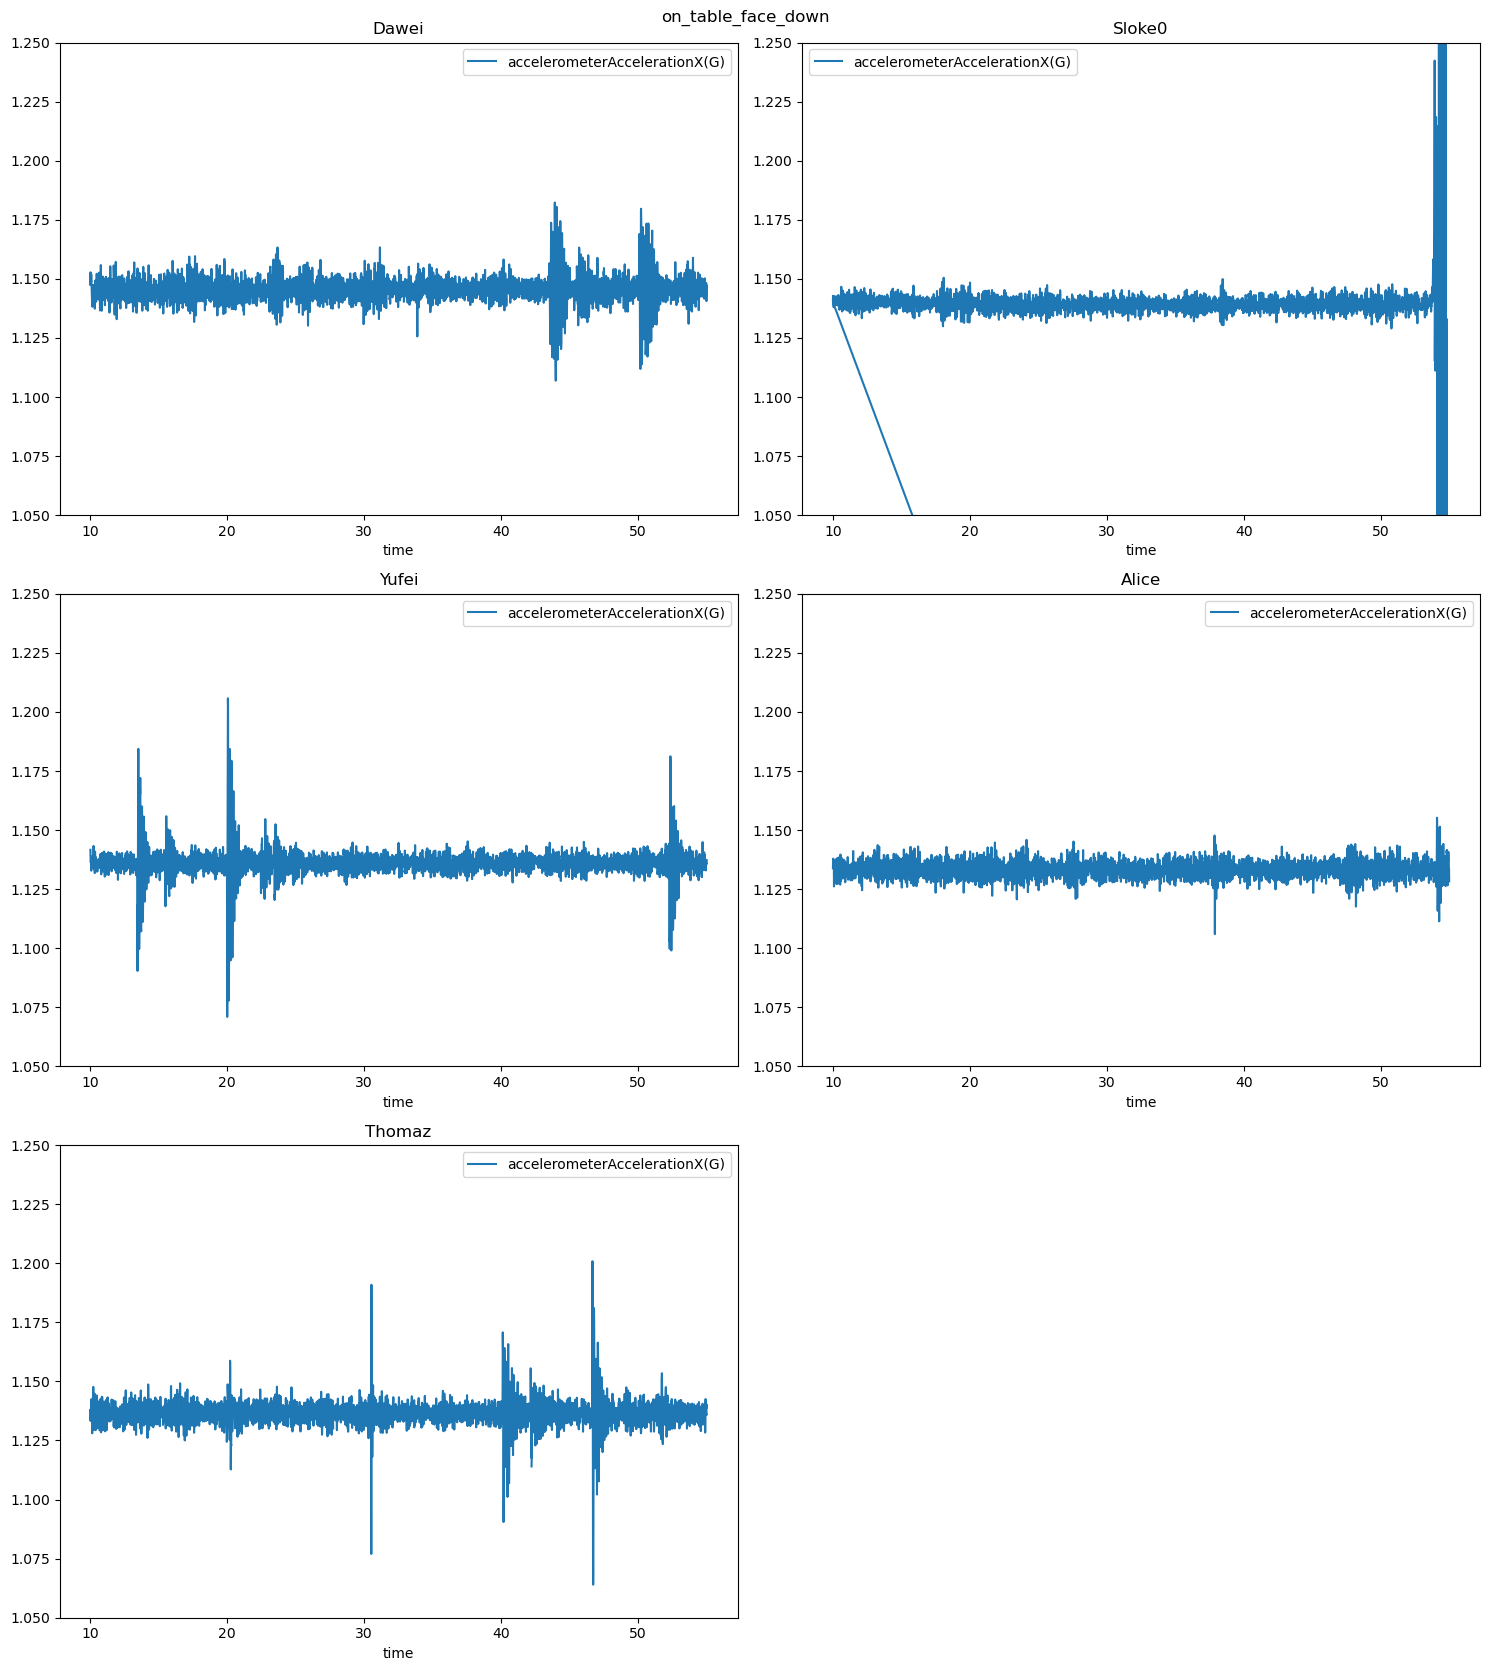

In [6]:
activity = "on_table_face_down"
activity_indices = df[df['activity']==activity].index
i = 1
plt.figure(figsize=(15, 17))

for person in person_list:
    person_indices = df[df['person']==person].index
    plot_indices = list(set(activity_indices) & set(person_indices))
    plot_df = df.loc[plot_indices]
    ax = plt.subplot(3, 2, i)
    plot_df.plot(x="time", y="accelerometerAccelerationX(G)", ax=ax)
    plt.title("{person}".format(person=person))
    plt.ylim([1.05, 1.25])
    i=i+1

plt.suptitle("{activity}".format(activity=activity))
plt.tight_layout()

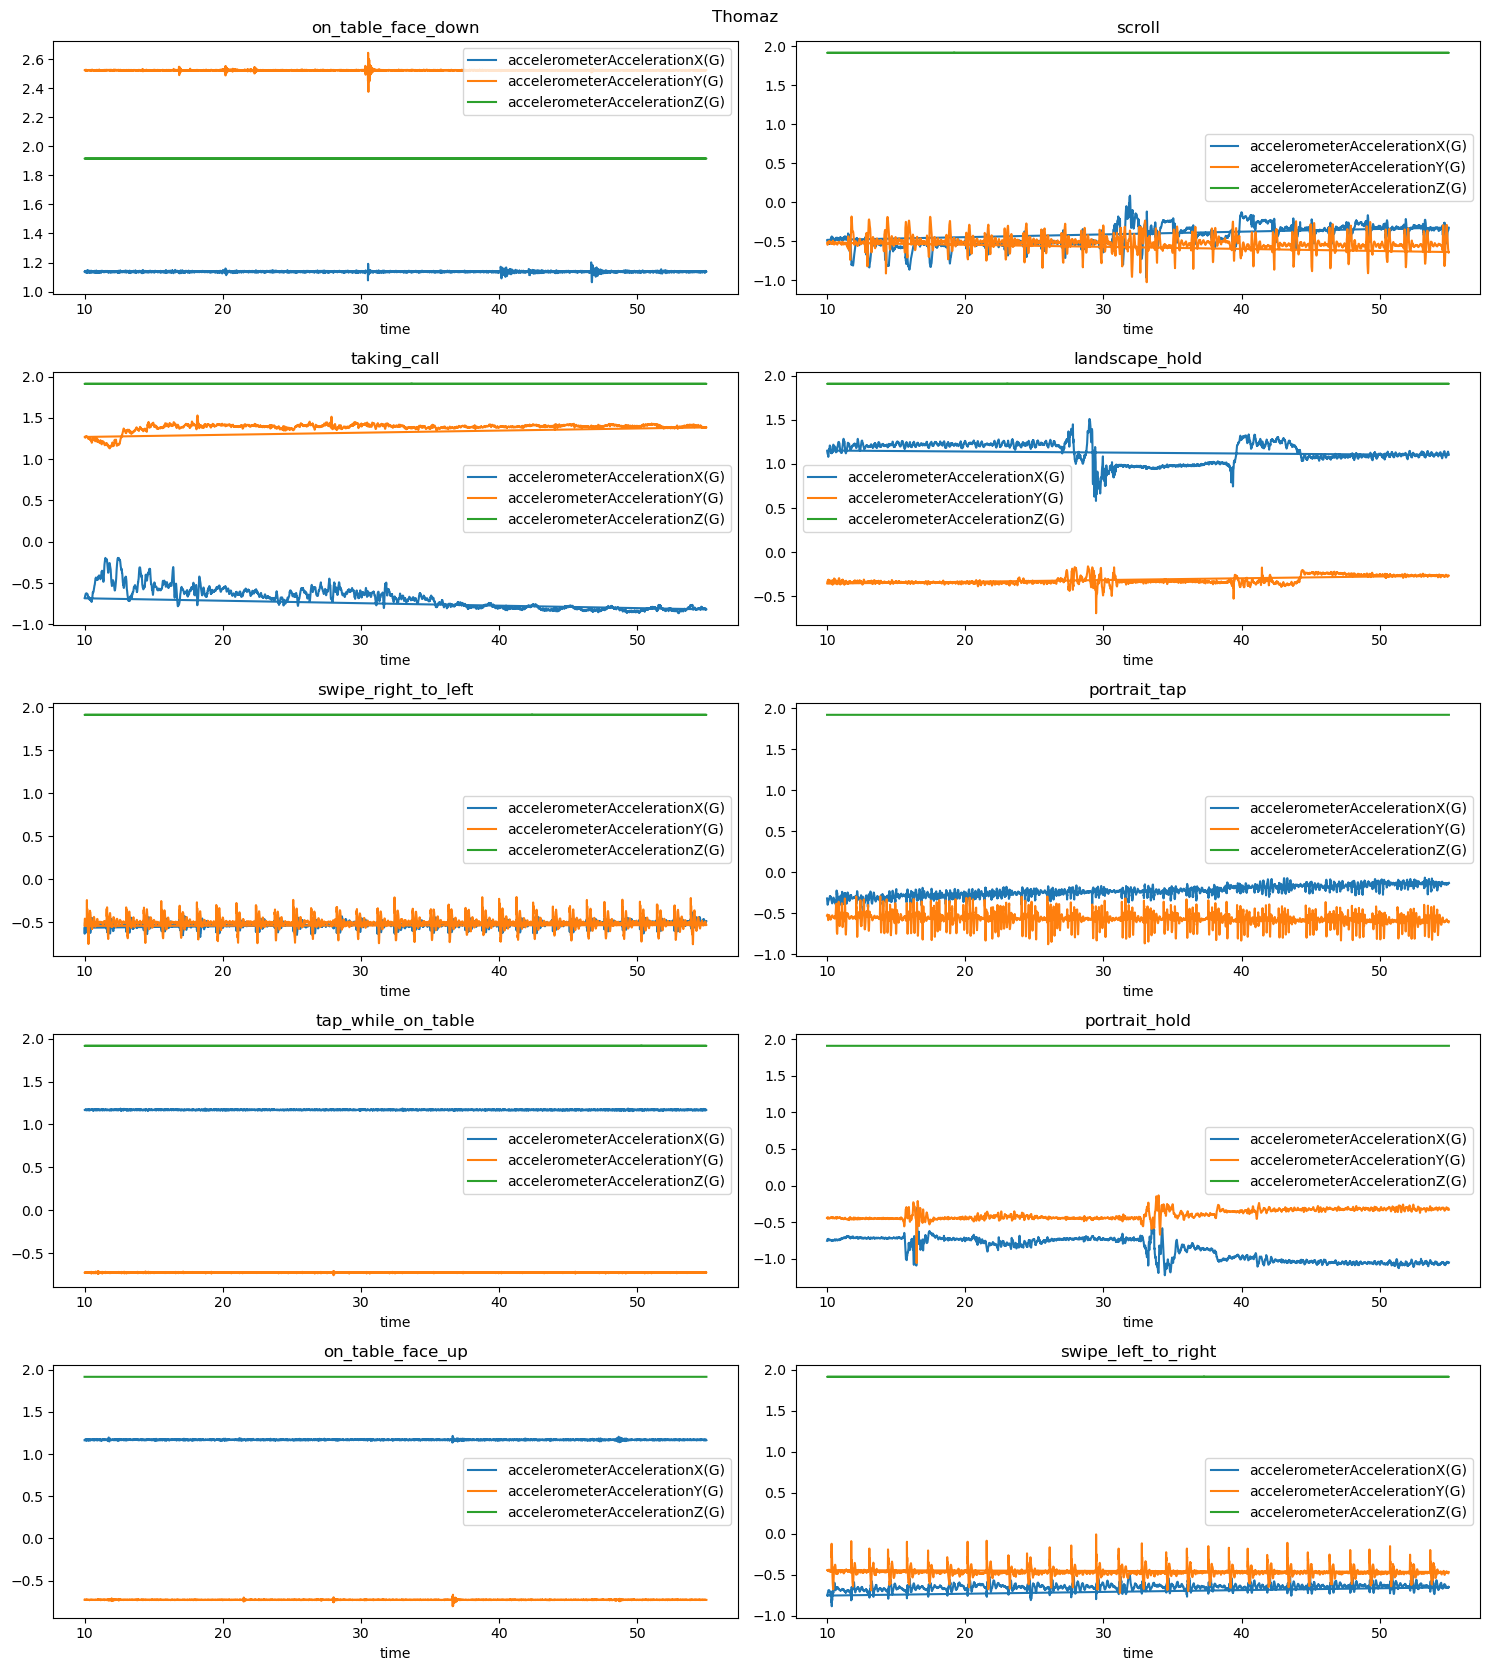

In [272]:
# plot raw normalized data, same participant across different activities
df = pre_process(path, subject="all")

activity_list = df['activity'].unique()
person_list = df['person'].unique()

person = "Thomaz"
person_indices = df[df['person']==person].index

i = 1
plt.figure(figsize=(15, 17))

for activity in activity_list:
    activity_indices = df[df['activity']==activity].index
    person_indices = df[df['person']==person].index
    plot_indices = list(set(activity_indices) & set(person_indices))
    plot_df = df.loc[plot_indices]
    ax = plt.subplot(5, 2, i)
    plot_df.plot(x="time", y="accelerometerAccelerationX(G)", ax=ax)
    plot_df.plot(x="time", y="accelerometerAccelerationY(G)", ax=ax)
    plot_df.plot(x="time", y="accelerometerAccelerationZ(G)", ax=ax)


    plt.title("{activity}".format(activity=activity))
    i=i+1

plt.suptitle("{person}".format(person=person))
plt.tight_layout()

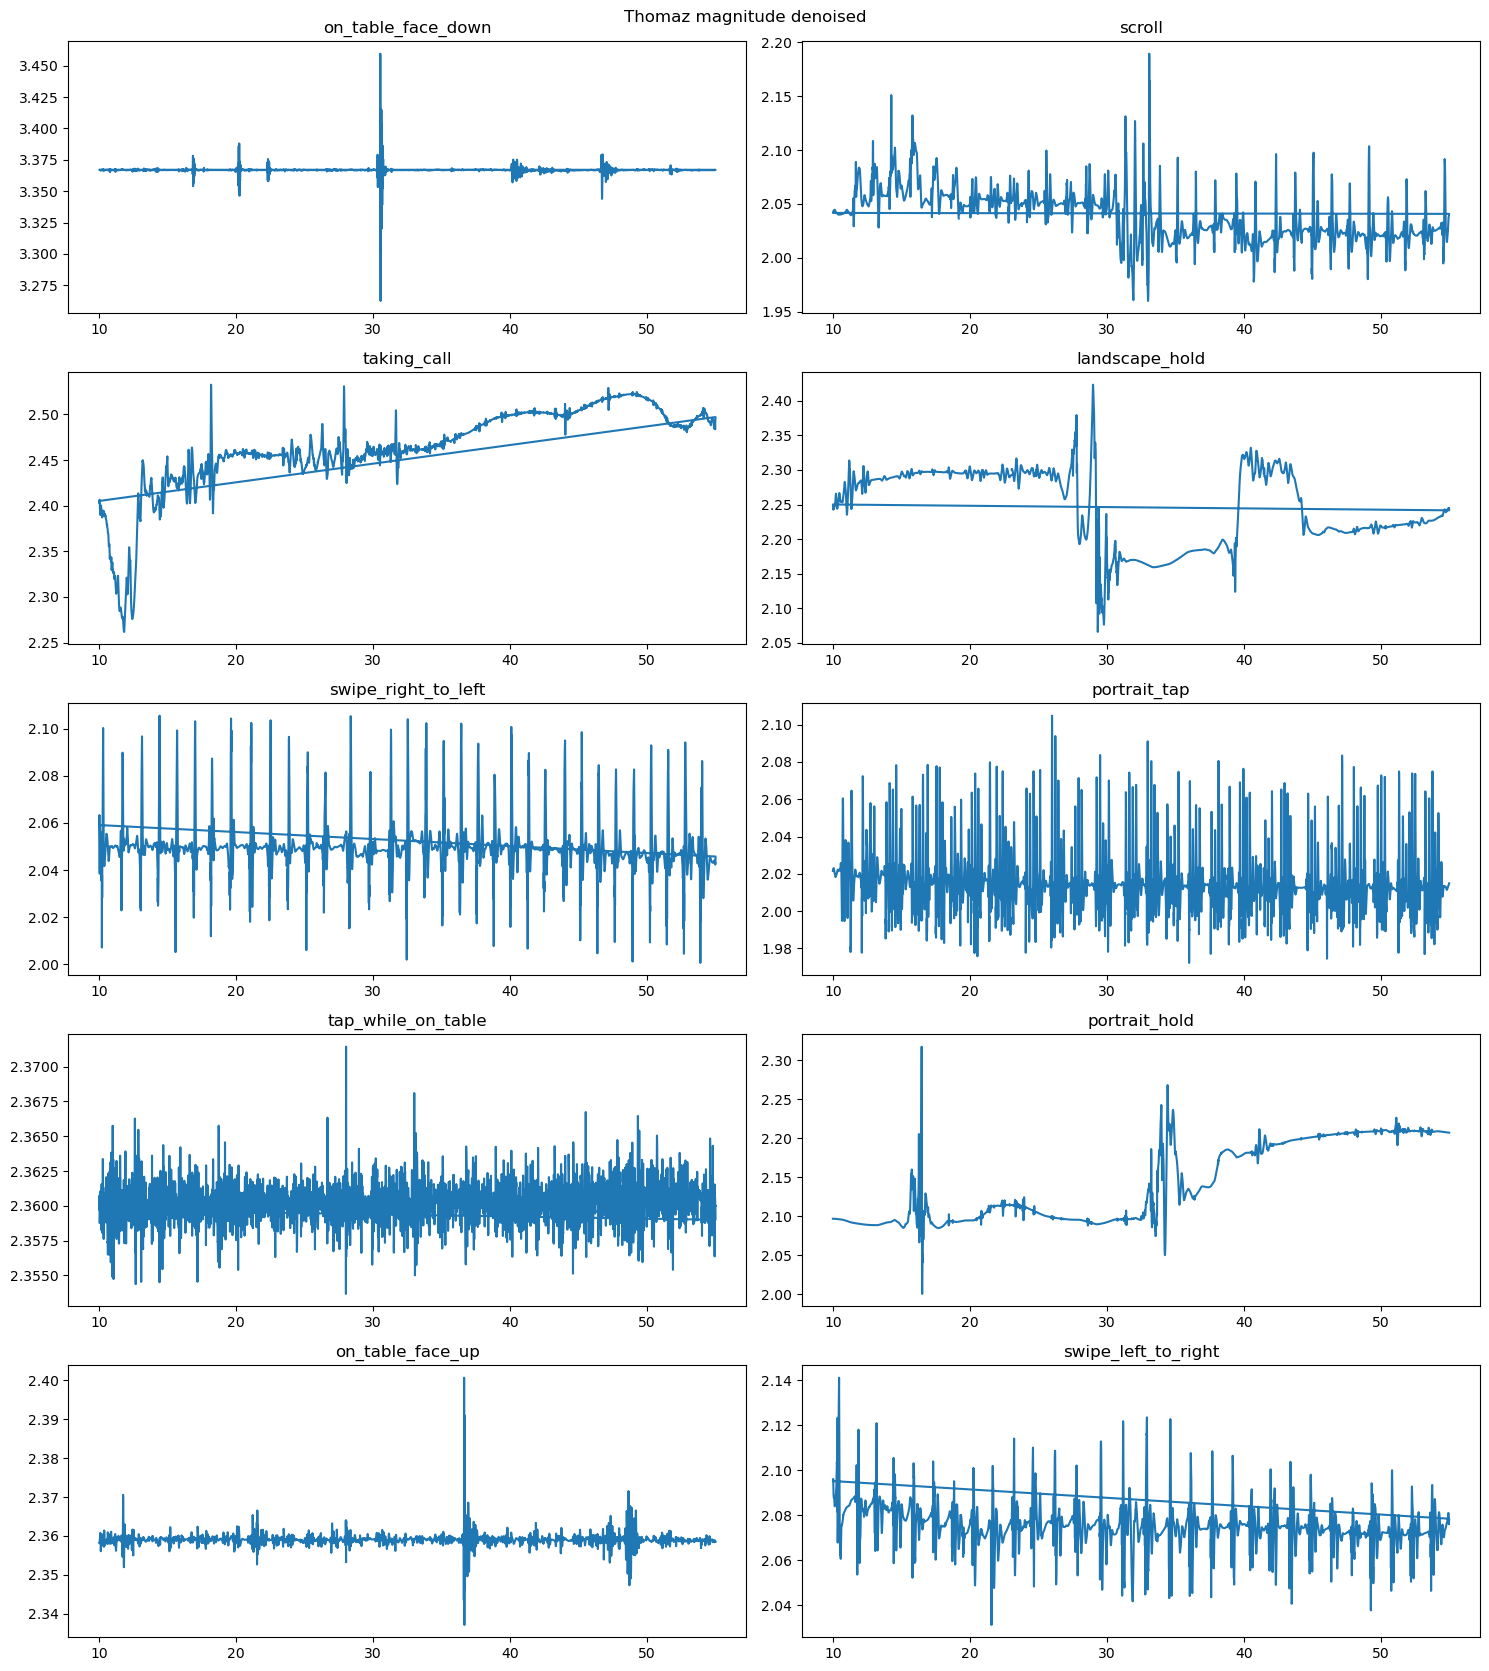

In [8]:
# plot denoised normalized data, same participant across different activities
df = pre_process(path, subject="all")

activity_list = df['activity'].unique()
person_list = df['person'].unique()

person = "Thomaz"
person_indices = df[df['person']==person].index

i = 0
fig, axs = plt.subplots(5,2, figsize=(15, 17))
axs = axs.ravel()

for activity in activity_list:
    activity_indices = df[df['activity']==activity].index
    person_indices = df[df['person']==person].index
    intersect_indices = list(set(activity_indices) & set(person_indices))

    intersect_df = df.loc[intersect_indices]
    x_acc = intersect_df['accelerometerAccelerationX(G)']
    y_acc = intersect_df['accelerometerAccelerationY(G)']
    z_acc = intersect_df['accelerometerAccelerationZ(G)'] 

    x_mag = [i**2 for i in x_acc]
    y_mag = [i**2 for i in y_acc]
    z_mag = [i**2 for i in z_acc]
    mag_sum = [sum(x) for x in zip(x_mag, y_mag, z_mag)]
    data = np.sqrt(mag_sum)

    w = pywt.Wavelet('sym4')
    maxlev = pywt.dwt_max_level(len(data), w.dec_len)
    threshold = 0.15 # Threshold for filtering
    # Decompose into wavelet components, to the level selected:
    coeffs = pywt.wavedec(data, 'sym4', level=maxlev)

    for j in range(1, len(coeffs)):
        coeffs[j] = pywt.threshold(coeffs[j], threshold*max(coeffs[j]))
    datarec = pywt.waverec(coeffs, 'sym4')

    #ax = plt.subplot(5, 2, i)
    axs[i].plot(intersect_df.time, datarec[0:-1])
    #plt.title("{activity}".format(activity=activity))
    axs[i].set_title("{activity}".format(activity=activity))
    i=i+1

plt.suptitle("{person} magnitude denoised".format(person=person))
plt.tight_layout()


/var/folders/4r/nqxrmy_s1v59t8sk2xs18tc40000gq/T/ipykernel_46876/1290346420.py:17: DeprecationWarning: Support for non-numeric arrays has been deprecated as of SciPy 1.9.0 and will be removed in 1.11.0. `pandas.DataFrame.mode` can be used instead, see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mode.html.
  label = stats.mode(df['activity'][i: i + frame_size])[0][0]
/var/folders/4r/nqxrmy_s1v59t8sk2xs18tc40000gq/T/ipykernel_46876/1290346420.py:17: DeprecationWarning: Support for non-numeric arrays has been deprecated as of SciPy 1.9.0 and will be removed in 1.11.0. `pandas.DataFrame.mode` can be used instead, see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mode.html.
  label = stats.mode(df['activity'][i: i + frame_size])[0][0]


Random forest classifier: 
mean precision: 0.41021254771254767 mean recall: 0.4422736418511066 mean F1 score: 0.3464412091864348 


/Users/az8797/miniforge3/envs/tensorflow-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


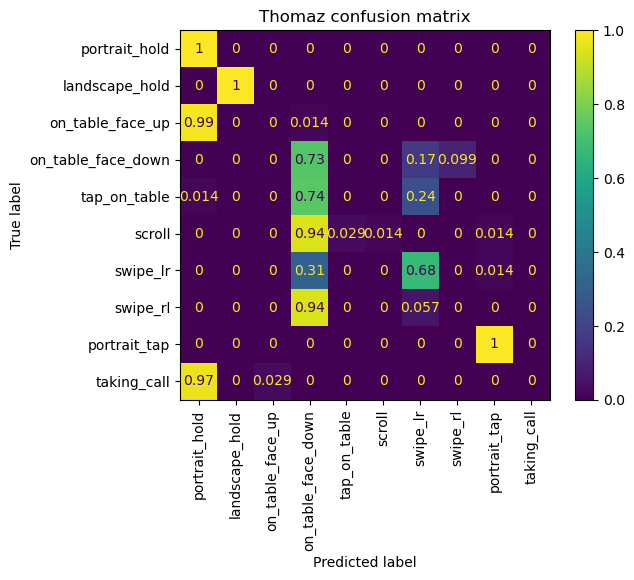

In [284]:
# leave one participant out validation
df = pre_process(path, subject="all")
#X, y = extract_features(df)

test_subject = "Thomaz"
test_indices = df[df['person']==test_subject].index
test_df = df.loc[test_indices]
X_test, y_test = extract_features(test_df)

train_indices = df[df['person']!=test_subject].index
train_df = df.loc[train_indices]
X_train, y_train = extract_features(train_df)

rf = RandomForestClassifier(n_estimators=30)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1_scores = f1_score(y_test, y_pred, average='macro')

print("Random forest classifier: ")
print("mean precision: {precision} mean recall: {recall} mean F1 score: {f1} ".format(recall=np.mean(recall), precision=np.mean(precision), f1=np.mean(f1_scores)))

# plot confusion matrix
labels = ['portrait_hold', 'landscape_hold', 'on_table_face_up', 'on_table_face_down', 'tap_on_table', 'scroll', 'swipe_lr', 'swipe_rl', 'portrait_tap', 'taking_call']
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.xticks(rotation='vertical')
plt.title("Thomaz confusion matrix")
plt.show()


/var/folders/4r/nqxrmy_s1v59t8sk2xs18tc40000gq/T/ipykernel_46876/2464483106.py:17: DeprecationWarning: Support for non-numeric arrays has been deprecated as of SciPy 1.9.0 and will be removed in 1.11.0. `pandas.DataFrame.mode` can be used instead, see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mode.html.
  label = stats.mode(df['activity'][i: i + frame_size])[0][0]


Random forest classifier: 
mean precision: 0.9818133997785161 mean recall: 0.9813955541430515 mean F1 score: 0.9810705114687547 


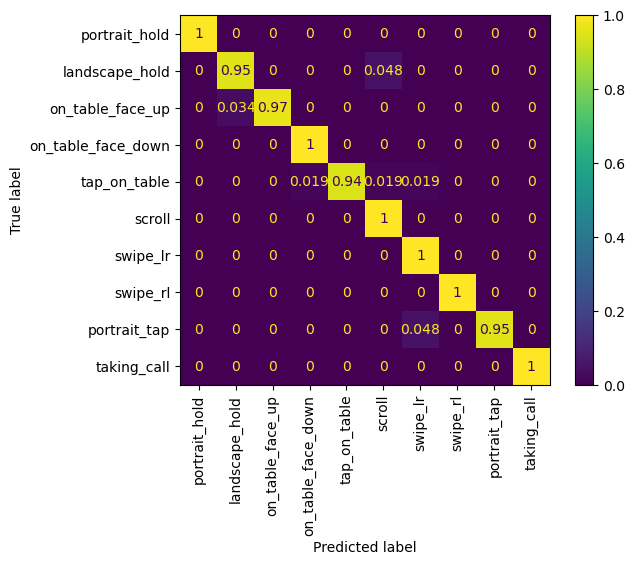

In [103]:
# 80/20 validation on Yufei only
df = pre_process(path, subject="Yufei")
X, y = extract_features(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0, stratify = y)
rf = RandomForestClassifier(n_estimators=30)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1_scores = f1_score(y_test, y_pred, average='macro')

print("Random forest classifier: ")
print("mean precision: {precision} mean recall: {recall} mean F1 score: {f1} ".format(recall=np.mean(recall), precision=np.mean(precision), f1=np.mean(f1_scores)))

# plot confusion matrix
labels = ['portrait_hold', 'landscape_hold', 'on_table_face_up', 'on_table_face_down', 'tap_on_table', 'scroll', 'swipe_lr', 'swipe_rl', 'portrait_tap', 'taking_call']
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.yticks(rotation='horizontal')
plt.xticks(rotation='vertical')
plt.show()